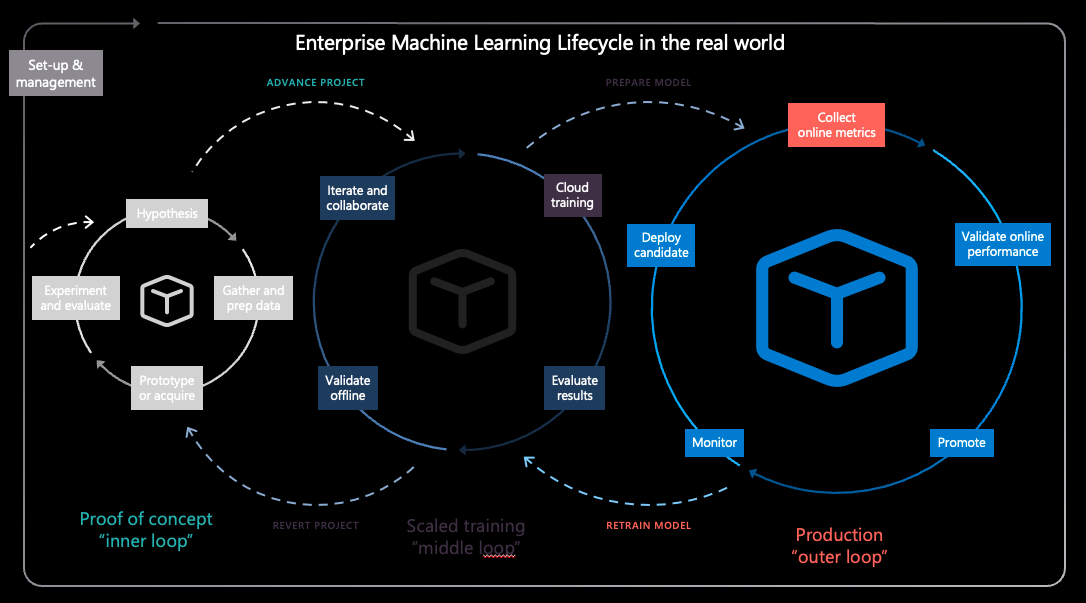

## Model Training @ Scale - Middle Loop 


Learn how a data scientist uses Azure Machine Learning to train a model.  In this example, we use the associated credit card dataset to show how you can use Azure Machine Learning for a classification problem. The goal is to predict if a customer has a high likelihood of defaulting on a credit card payment.

The training script handles the data preparation, then trains and registers a model. This tutorial takes you through steps to submit a cloud-based training job (command job). If you would like to learn more about how to load your data into Azure, see [Create data assets](how-to-create-data-assets.md). 

The steps are:

 * Get a handle to your Azure Machine Learning workspace
 * Create your compute resource and job environment
 * Create your training script
 * Create and run your command job to run the training script on the compute resource, configured with the appropriate job environment and the data source
 * View the output of your training script
 * Deploy the newly-trained model as an endpoint
 * Call the Azure Machine Learning endpoint for inferencing

## Prerequisites

## Set your kernel

* If your compute instance is stopped, start it now.  
        
    ![Start compute](./media/start-compute.png)

* Once your compute instance is running, make sure the that the kernel, found on the top right, is 'Aml SDKv2 Py3_8' (if you followed notebook 00_SetupIpythonKernel).

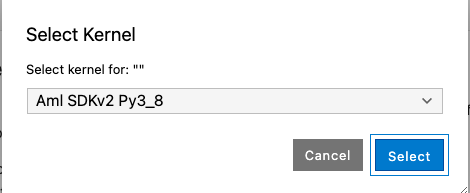

If not, use the dropdown to select this kernel.
   
![Set the kernel](./media/set-kernel.png)

## Use a command job to train a model in Azure Machine Learning

To train a model, you need to submit a *job*. The type of job you'll submit in this tutorial is a *command job*. Azure Machine Learning offers several different types of jobs to train models. Users can select their method of training based on complexity of the model, data size, and training speed requirements.  In this tutorial, you'll learn how to submit a *command job* to run a *training script*. 

A command job is a function that allows you to submit a custom training script to train your model. This can also be defined as a custom training job. A command job in Azure Machine Learning is a type of job that runs a script or command in a specified environment. You can use command jobs to train models, process data, or any other custom code you want to execute in the cloud. 

In this tutorial, we'll focus on using a command job to create a custom training job that we'll use to train a model. For any custom training job, the below items are required:

* compute resource (usually a compute cluster, which we recommend for scalability)
* environment
* data
* command job 
* training script


In this tutorial we'll provide all these items for our example: creating a classifier to predict customers who have a high likelihood of defaulting on credit card payments.


## Load local environment

For the purposes of this tutorial, environment variables used during the exercise are stored in a .env file.  Please create or modify your local .env file prior to the next steps.

Load local environment from the .env file

(Optional) If not already installed, install environment management package

In [ ]:
!conda install python-dotenv

### Set environment variable values

- Step 1: Copy the provided .env.sample and rename it to .env
- Step 2: Set the variables in the newly created .env file to your account-specific values
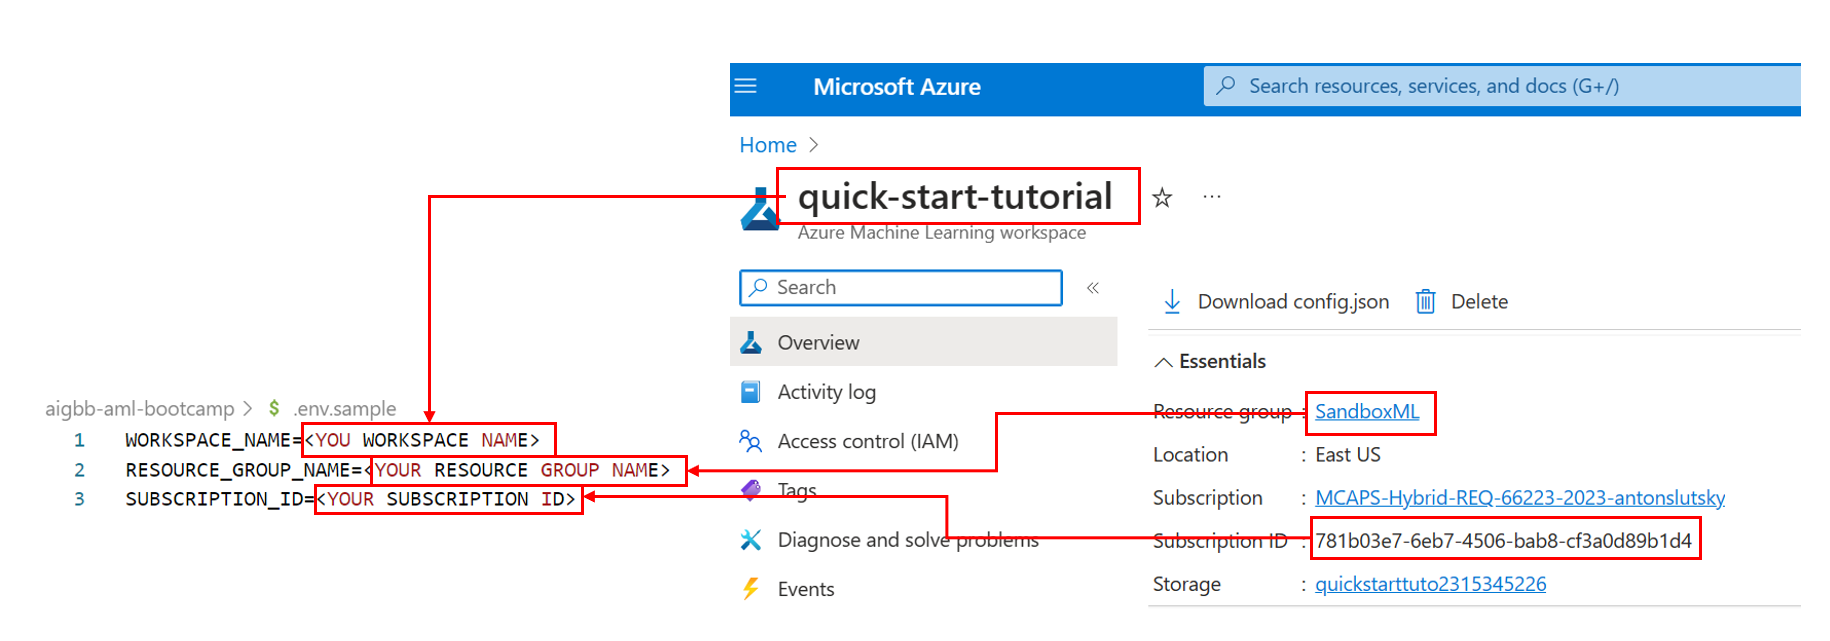
- Step 3: Proceed to the next step 

### Load environment

In [3]:
%reload_ext dotenv
%dotenv

##### Configure Azure ML session

It is now necessary to configure local Azure ML session to point to the appropriate workspace and resource group.  The following code configures local CLI environment for subsequent use.

In [4]:
import platform 
current_platform = platform.system()
if "Windows" == current_platform:
    !az configure --defaults workspace=%WORKSPACE_NAME% group=%RESOURCE_GROUP_NAME%
else:
    !az configure --defaults workspace=$WORKSPACE_NAME group=$RESOURCE_GROUP_NAME

## Create a compute cluster to run your job

In Azure, a job can refer to several tasks that Azure allows its users to do: training, pipeline creation, deployment, etc. For this tutorial and our purpose of training a machine learning model, we'll use *job* as a reference to running training computations (*training job*).

You need a compute resource for running any job in Azure Machine Learning. It can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like Spark. In Azure, there are two compute resources that you can choose from: instance and cluster. A compute instance contains one node of computation resources while a *compute cluster* contains several. A *compute cluster* contains more memory for the computation task. For training, we recommend using a compute cluster because it allows the user to distribute calculations on multiple nodes of computation, which results in a faster training experience. 

You provision a Linux compute cluster. See the [full list on VM sizes and prices](https://azure.microsoft.com/pricing/details/machine-learning/) .

For this example, you only need a basic cluster, so you use a Standard_DS3_v2 model with 2 vCPU cores, 7-GB RAM.

(Optional) If not installed before, install Azure ML Extension to the CLI environment

In [ ]:
!az extension remove -n azure-cli-ml
!az extension remove -n ml

In [ ]:
!az extension add -n ml

Verify extension installation

In [ ]:
!az ml -h

Use the Azure ML CLI extension to create a compute cluster that will be used in later steps to execute the training job

In [5]:
%env CLUSTER_NAME cpu-cluster-test

if "Windows" == current_platform:

    !az ml compute create -n %CLUSTER_NAME% --type amlcompute \
        --min-instances 0 \
        --max-instances 4 \
        --size STANDARD_DS3_V2 \
        --idle-time-before-scale-down 180 \
        --tier Dedicated \
        --resource-group %RESOURCE_GROUP_NAME% \
        --workspace-name %WORKSPACE_NAME%
else:
    !az ml compute create -n %CLUSTER_NAME% --type amlcompute \
        --min-instances 0 \
        --max-instances 4 \
        --size STANDARD_DS3_V2 \
        --idle-time-before-scale-down 180 \
        --tier Dedicated \
        --resource-group $RESOURCE_GROUP_NAME \
        --workspace-name $WORKSPACE_NAME

env: CLUSTER_NAME=cpu-cluster-test
{
  "enable_node_public_ip": true,
  "id": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/computes/cpu-cluster-test",
  "idle_time_before_scale_down": 180,
  "location": "eastus",
  "max_instances": 4,
  "min_instances": 0,
  "name": "cpu-cluster-test",
  "network_settings": {},
  "provisioning_state": "Succeeded",
  "resourceGroup": "SandboxML",
  "size": "STANDARD_DS3_V2",
  "ssh_public_access_enabled": true,
  "tier": "dedicated",
  "type": "amlcompute"
}


## Create a job-specific dependencies configuration (if it does not yet exist)

To run your Azure Machine Learning job on your compute resource, you need an [environment](https://learn.microsoft.com/articles/machine-learning/concept-environments). An environment lists the software runtime and libraries that you want installed on the compute where you’ll be training. It's similar to your python environment on your local machine.

Azure Machine Learning provides many curated or ready-made environments, which are useful for common training and inference scenarios. 

In this example, you'll create a custom conda environment for your jobs, using a conda yaml file.

First, create a directory to store the file in.

The cell below uses IPython magic to write the conda file into the directory you just created.

In [7]:
%%writefile dependencies/conda.yml
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - inference-schema[numpy-support]==1.3.0
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - psutil>=5.8,<5.9
    - tqdm>=4.59,<4.60
    - ipykernel~=6.0
    - matplotlib
    - pyarrow
    - python-dotenv


Overwriting dependencies/conda.yml



The specification contains some usual packages, that you'll use in your job (numpy, pip).

### CLI Job Configuration

Now create a job configuration file that references the conda.yml (above) to create a job and initialize execution.

In [8]:
%%writefile dependencies/cli_job.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: ../src
command: >-
  python main.py 
  --data ${{inputs.data}} 
  --test_train_ratio ${{inputs.test_train_ratio}} 
  --learning_rate ${{inputs.learning_rate}} 
  --registered_model_name ${{inputs.registered_model_name}}
inputs:
  data: 
    type: uri_file
    path: azureml:credit-card_csv:2023.10.05.154542
  test_train_ratio: 0.2
  learning_rate: 0.25
  registered_model_name: credit_default_model
environment: 
  image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
  conda_file: conda.yml #### <--- CONDA.YML
compute: azureml:cpu-cluster #### <---- COMPUTE RESOURCE
display_name: sklearn-iris-example
experiment_name: sklearn-iris-example
description: Train a scikit-learn SVM on the Iris dataset.


Overwriting dependencies/cli_job.yml


## Configure a training job using the command function

You create an Azure Machine Learning *command job* to train a model for credit default prediction. The command job runs a *training script* in a specified environment on a specified compute resource.  You've already created the environment and the compute cluster.  Next you'll create the training script. In our specific case, we're training our dataset to produce a classifier using the `GradientBoostingClassifier` model. 

The *training script* handles the data preparation, training and registering of the trained model. The method `train_test_split` handles splitting the dataset into test and training data. In this tutorial, you'll create a Python training script. 

Command jobs can be run from CLI, Python SDK, or studio interface. In this tutorial, you'll use the Azure Machine Learning Python SDK v2 to create and run the command job.

## Create training script

Let's start by creating the training script - the *main.py* python file.

First create a source folder for the script:

In [9]:
!mkdir src

A subdirectory or file src already exists.


This script handles the preprocessing of the data, splitting it into test and train data. It then consumes this data to train a tree based model and return the output model. 

[MLFlow](https://learn.microsoft.com/articles/machine-learning/concept-mlflow) is used to log the parameters and metrics during our job. The MLFlow package allows you to keep track of metrics and results for each model Azure trains. We'll be using MLFlow to first get the best model for our data, then we'll view the model's metrics on the Azure studio. 

In [10]:
%%writefile src/main.py
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--n_estimators", required=False, default=100, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    args = parser.parse_args()
   
    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    ###################
    #<prepare the data>
    ###################
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)
    
    credit_df = pd.read_csv(args.data, header=1, index_col=0)

    mlflow.log_metric("num_samples", credit_df.shape[0])
    mlflow.log_metric("num_features", credit_df.shape[1] - 1)

    #Split train and test datasets
    train_df, test_df = train_test_split(
        credit_df,
        test_size=args.test_train_ratio,
    )
    ####################
    #</prepare the data>
    ####################

    ##################
    #<train the model>
    ##################
    # Extracting the label column
    y_train = train_df.pop("default payment next month")

    # convert the dataframe values to array
    X_train = train_df.values

    # Extracting the label column
    y_test = test_df.pop("default payment next month")

    # convert the dataframe values to array
    X_test = test_df.values

    print(f"Training with data of shape {X_train.shape}")

    clf = GradientBoostingClassifier(
        n_estimators=args.n_estimators, learning_rate=args.learning_rate
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    ###################
    #</train the model>
    ###################

    ##########################
    #<save and register model>
    ##########################
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=clf,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################
    
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

Overwriting src/main.py


In this script, once the model is trained, the model file is saved and registered to the workspace. Registering your model allows you to store and version your models in the Azure cloud, in your workspace. Once you register a model, you can find all other registered model in one place in the Azure Studio called the model registry. The model registry helps you organize and keep track of your trained models. 

## Create and submit the job

Now that you have a script that can perform the classification task, use the general purpose **command** that can run command line actions. This command line action can be directly calling system commands or by running a script. 

Here, create input variables to specify the input data, split ratio, learning rate and registered model name.  The command script will:
* Use the compute created earlier to run this command.
* Use the environment created earlier - you can use the `@latest` notation to indicate the latest version of the environment when the command is run.
* Configure the command line action itself - `python main.py` in this case. The inputs/outputs are accessible in the command via the `${{ ... }}` notation.

Input and Output data How to:
https://learn.microsoft.com/en-us/azure/machine-learning/how-to-read-write-data-v2?view=azureml-api-2&tabs=python

In [5]:
!az ml job create -f dependencies\cli_job.yaml --query name -o tsv

nifty_band_sbvpr399rc


Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


## View job output and wait for job completion

View the job in Azure Machine Learning studio by selecting the link in the output of the previous cell. The output of this job will look like this in the Azure Machine Learning studio. Explore the tabs for various details like metrics, outputs etc. Once completed, the job will register a model in your workspace as a result of training. 

![Screenshot shows the overview page for the job.](./media/view-job.gif)

> [!IMPORTANT]
> Wait until the status of the job is complete before returning to this notebook to continue. The job will take 2 to 3 minutes to run. It could take longer (up to 10 minutes) if the compute cluster has been scaled down to zero nodes and custom environment is still building.

When you run the cell, the notebook output shows a link to the job's details page on Azure Studio. Alternatively, you can also select Jobs on the left navigation menu. A job is a grouping of many runs from a specified script or piece of code. Information for the run is stored under that job. The details page gives an overview of the job, the time it took to run, when it was created, etc. The page also has tabs to other information about the job such as metrics, Outputs + logs, and code. Listed below are the tabs available in the job's details page:

* Overview: The overview section provides basic information about the job, including its status, start and end times, and the type of job that was run
* Inputs: The input section lists the data and code that were used as inputs for the job. This section can include datasets, scripts, environment configurations, and other resources that were used during training. 
* Outputs + logs: The Outputs + logs tab contains logs generated while the job was running. This tab assists in troubleshooting if anything goes wrong with your training script or model creation.
* Metrics: The metrics tab showcases key performance metrics from your model such as training score, f1 score, and precision score. 

## Clean up resources

If you plan to continue now to other tutorials, skip to [Next steps](#next-steps).

### Stop compute instance

If you're not going to use it now, stop the compute instance:

1. In the studio, in the left navigation area, select **Compute**.
1. In the top tabs, select **Compute instances**
1. Select the compute instance in the list.
1. On the top toolbar, select **Stop**.


## Next Steps
Learn about deploying a model 

[Deploy a model](https://learn.microsoft.com/articles/machine-learning/tutorial-deploy-model).

This tutorial used an online data file.  To learn more about other ways to access data, see [Tutorial: Upload, access and explore your data in Azure Machine Learning](https://learn.microsoft.com/articles/machine-learning/tutorial-explore-data).

If you would like to learn more about different ways to train models in Azure Machine Learning, see [What is automated machine learning (AutoML)?](https://learn.microsoft.com/articles/machine-learning/concept-automated-ml). Automated ML is a supplemental tool to reduce the amount of time a data scientist spends finding a model that works best with their data.

If you would like more examples similar to this tutorial, see [**Samples**](https://learn.microsoft.com/articles/machine-learning/quickstart-create-resources#learn-from-sample-notebooks) section of studio. These same samples are available at our [GitHub examples page.](https://github.com/Azure/azureml-examples) The examples include complete Python Notebooks that you can run code and learn to train a model. You can modify and run  existing scripts from the samples, containing scenarios including classification, natural language processing, and anomaly detection. 

To train models by creating your own custom environments using a [docker image,](how-to-manage-environments-v2.md#create-an-environment-from-a-docker-build-context).